In [19]:
import pandas as pd
import numpy as np
from biotite.sequence.phylo import neighbor_joining
from ete3 import Tree
from tqdm import tqdm

In [20]:
def calculate_chemical_distance(data):
    n_stars = len(data.index)
    matrix_distance = np.zeros(shape=(n_stars, n_stars))  
    for i, star_i in enumerate(data.index):
        for j, star_j in enumerate(data.index):
            c = 0  
            for c_elem in data.columns:
                c += np.abs(data.loc[star_i, c_elem] - data.loc[star_j, c_elem])
            matrix_distance[i, j] = c
      
    return matrix_distance


In [21]:
def generate_new_chemical_matrix(data,stds,factor):
    new_matrix = data.copy()
    for i,star in enumerate(data.index):
        for j,elem_chemical in enumerate(data.columns):
            if elem_chemical != '[Fe/H]':
                new_matrix.loc[star,elem_chemical] = np.random.normal(loc=data.loc[star,elem_chemical]+factor,scale=factor*stds.loc[elem_chemical,'std'])
            else:
                new_matrix.loc[star,elem_chemical] = data.loc[star,elem_chemical]
    return new_matrix

In [22]:
import re
import random 
def generate_trees(data,stds,path,n,factor=1):
    with open(path,'w') as f:
        for i in range(n):
            random_chemical_elements = data.sample(n=random.randint(len(data.columns)//2,len(data.columns)),axis=1) #subsample de concentraciones
            chemical_matrix = generate_new_chemical_matrix(random_chemical_elements,stds,factor) #modificacion a las concentraciones quimicas
            matrix_distance = calculate_chemical_distance(chemical_matrix)
            tree = neighbor_joining(matrix_distance)
            graph = tree.to_newick(include_distance=True)
            pattern = r"([a-zA-Z0-9_]+):" #creo que esta parte se puede arreglar, no sé si en Python o Mesquite.
            replace_map = dict(enumerate(data.index))
            def replace_taxon(match):
                taxon_name = int(match.group(1))
                return replace_map.get(taxon_name, taxon_name) + ":"  
            new_newick_tree = re.sub(pattern, replace_taxon, graph)
            new_newick_tree = new_newick_tree.replace("*", "_")
            new_newick_tree = new_newick_tree.replace(" ", "_")

            f.write(str(new_newick_tree) + "\n")

In [23]:
df = pd.read_csv('tabla_descargada.csv')
df.set_index('Star',inplace=True)
df.head()

,T eff,log g,[Fe/H],ξ turb,[C/Fe],[O/Fe],[Na/Fe],[Mg/Fe],[Al/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe],[Cr/Fe],[Ni/Fe],[Zn/Fe],[Y/Fe]
Star,,,,,,,,,,,,,,,,,
HD 2071,5724,4.490,−0.084,0.96,−0.022,−0.022,−0.032,0.001,−0.002,0.001,−0.007,0.024,0.019,0.005,−0.029,−0.026,0.040
HD 8406,5730,4.479,−0.105,0.95,−0.036,−0.028,−0.059,0.000,−0.020,−0.010,−0.021,0.031,0.009,0.010,−0.041,−0.044,0.050
HD 20782,5776,4.345,−0.058,1.04,−0.019,0.024,−0.086,0.011,0.015,−0.006,−0.013,0.015,0.028,−0.004,−0.042,−0.019,−0.110
HD 27063,5779,4.469,0.064,0.99,−0.082,−0.078,−0.041,−0.018,−0.029,−0.019,−0.039,0.023,−0.005,0.016,−0.022,−0.055,0.067
HD 28471,5754,4.380,−0.054,1.02,−0.023,0.006,−0.013,0.037,0.065,0.022,−0.010,0.026,0.046,−0.007,−0.005,0.018,−0.067


In [24]:
data_r = df.drop(['T eff','log g','ξ turb'],axis=1)
data_r.replace('−', '-', regex=True,inplace=True)

data_r = data_r.astype(np.float64)
data_r.head()

,[Fe/H],[C/Fe],[O/Fe],[Na/Fe],[Mg/Fe],[Al/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe],[Cr/Fe],[Ni/Fe],[Zn/Fe],[Y/Fe]
Star,,,,,,,,,,,,,,
HD 2071,-0.084,-0.022,-0.022,-0.032,0.001,-0.002,0.001,-0.007,0.024,0.019,0.005,-0.029,-0.026,0.040
HD 8406,-0.105,-0.036,-0.028,-0.059,0.000,-0.020,-0.010,-0.021,0.031,0.009,0.010,-0.041,-0.044,0.050
HD 20782,-0.058,-0.019,0.024,-0.086,0.011,0.015,-0.006,-0.013,0.015,0.028,-0.004,-0.042,-0.019,-0.110
HD 27063,0.064,-0.082,-0.078,-0.041,-0.018,-0.029,-0.019,-0.039,0.023,-0.005,0.016,-0.022,-0.055,0.067
HD 28471,-0.054,-0.023,0.006,-0.013,0.037,0.065,0.022,-0.010,0.026,0.046,-0.007,-0.005,0.018,-0.067


In [25]:
stds = pd.DataFrame.from_dict({'[C/Fe]':0.009, '[O/Fe]':0.008, '[Na/Fe]':0.002, '[Mg/Fe]':0.002, '[Al/Fe]':0.002,
       '[Si/Fe]':0.004, '[S/Fe]':0.009, '[Ca/Fe]':0.002, '[Ti/Fe]':0.007, '[Cr/Fe]':0.001, '[Ni/Fe]':0.001,
       '[Zn/Fe]':0.004, '[Y/Fe]':0.007},orient='index',columns=['std'])

In [37]:
generate_trees(data_r,stds,'g1.data',100)
#generate_trees(data_r,stds,'g2.data',100,3)

In [38]:
from ete3 import Tree
import random
def modify_trees(path):
    with open(path,'r') as f:
        lines = f.readlines()
    with open('g2.data','w') as f:
        for newick in lines:
            tree = Tree(newick)
            leaves = tree.get_leaves()
            for i in range(random.randint(1,len(leaves)//3)):
                l1,l2 = random.sample(leaves,2)
                aux = l2.name
                l2.name = l1.name
                l1.name = aux
                
            new_newick = tree.write(format=1)
            f.write(new_newick+"\n")

In [39]:
modify_trees('g1.data')

# Generando el contraste D1  
- Primero hay que ejecutar el archivo los bloques de arriba
- Luego el archivo test.bat

In [1]:
with open('RF_values.txt','r') as f:
    text = f.readlines()
    d1_rf = []
    for val in text:
        d1_rf.append(float(val))

In [2]:
with open('ASD_values.txt','r') as f:
    text = f.readlines()
    d1_asd = []
    for val in text:
        d1_asd.append(float(val))
    

In [3]:
with open('PID_values.txt','r') as f:
    text = f.readlines()
    d1_pid = []
    for val in text:
        d1_pid.append(float(val))
    

In [4]:
with open('CID_values.txt','r') as f:
    text = f.readlines()
    d1_cid = []
    for val in text:
        d1_cid.append(float(val))
    

In [5]:
with open('MSD_values.txt','r') as f:
    text = f.readlines()
    d1_msd = []
    for val in text:
        d1_msd.append(float(val))
    

In [6]:
with open('WRF_values.txt','r') as f:
    text = f.readlines()
    d1_wrf = []
    for val in text:
        d1_wrf.append(float(val))

In [7]:
with open('EGR_values.txt','r') as f:
    text = f.readlines()
    d1_egr = []
    for val in text:
        d1_egr.append(float(val))

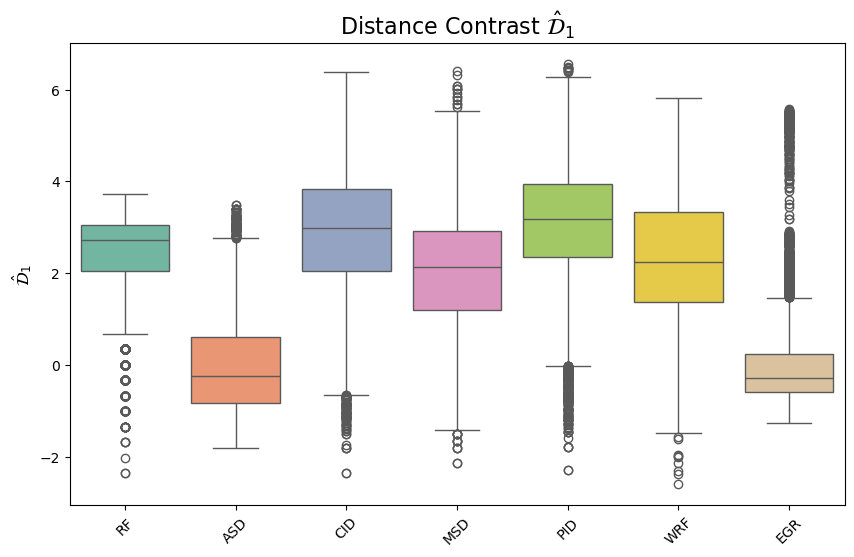

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

xd = {'RF':d1_rf,'ASD':d1_asd,'CID':d1_cid,'MSD':d1_msd,'PID':d1_pid,'WRF':d1_wrf,'EGR':d1_egr}
df = pd.DataFrame(xd)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, palette="Set2")

plt.title("Distance Contrast $\\hat{\\mathcal{D}}_1$", fontsize=16)
plt.ylabel("$\\hat{\\mathcal{D}}_1$", fontsize=12)
plt.xticks(fontsize=10, rotation=45)  
plt.yticks(fontsize=10)

plt.show()
